In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_utils import BasicFunctions, PriceFunctions
import math
import tensorflow as tf

%matplotlib inline

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
bf = BasicFunctions()
pf = PriceFunctions()

In [3]:
mean, std, pd_Xtrain, pd_ytrain, pd_Xtest, pd_ytest, Xtrain, ytrainOrig, Xtest, ytestOrig = pf.return_data()

In [4]:
ytrain = bf.convert_to_one_hot(ytrainOrig, 9)
ytest = bf.convert_to_one_hot(ytestOrig, 9)

In [5]:
Xtrain.shape

(35923, 5)

In [6]:
def create_placeholders():
    X = tf.placeholder(tf.float32, shape=(None, 5), name='X')
    y = tf.placeholder(tf.int32, shape=(None, 9), name='y')
    
    return X,y

In [7]:
def forward_propagation(X, training):
    Z1 = tf.layers.dense(X, 12, name='Z1', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    bn1 = tf.layers.batch_normalization(Z1, training=training, name='bn1')
    ac1 = tf.nn.relu(bn1, name='ac1')
    A1 = tf.layers.dropout(ac1, 0.3, name='A1')
    
    Z2 = tf.layers.dense(A1, 8, name='Z2', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    bn2 = tf.layers.batch_normalization(Z2, training=training, name='bn2')
    ac2 = tf.nn.relu(bn2, name='ac2')
    A2 = tf.layers.dropout(ac2, 0.3, name='A2')
    
    Z3 = tf.layers.dense(A2, 9, name='Z3', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    #AL = tf.nn.softmax(Z3)
    return Z3

In [8]:
def cost_function(AL, y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=AL))
    return cost

In [9]:
import os
cwd = os.getcwd()

from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

Iteration: 0 Cost: 2.725445032119751
Iteration: 10 Cost: 2.2606911659240723
Iteration: 20 Cost: 1.939623236656189
Iteration: 30 Cost: 1.6958777904510498
Iteration: 40 Cost: 1.5247739553451538
Iteration: 50 Cost: 1.420241355895996
Iteration: 60 Cost: 1.3144503831863403
Iteration: 70 Cost: 1.240983009338379
Iteration: 80 Cost: 1.1933889389038086
Iteration: 90 Cost: 1.1564390659332275
Iteration: 100 Cost: 1.1289771795272827
Iteration: 110 Cost: 1.1066019535064697
Iteration: 120 Cost: 1.087171196937561
Iteration: 130 Cost: 1.0768533945083618
Iteration: 140 Cost: 1.0698834657669067
Iteration: 150 Cost: 1.064395546913147
Iteration: 160 Cost: 1.060178518295288
Iteration: 170 Cost: 1.056771159172058
Iteration: 180 Cost: 1.0535979270935059
Iteration: 190 Cost: 1.0502690076828003
Iteration: 200 Cost: 1.043328046798706
Iteration: 210 Cost: 1.0392589569091797
Iteration: 220 Cost: 1.0345759391784668
Iteration: 230 Cost: 1.0311589241027832
Iteration: 240 Cost: 1.0274723768234253
Iteration: 250 Cost:

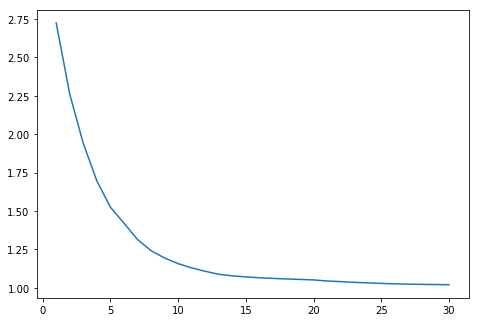

In [24]:
tf.reset_default_graph()

with tf.name_scope('Initialize'):
    X, y = create_placeholders()
    training = tf.placeholder(tf.bool, shape=(), name='training')
    
with tf.name_scope('ForwardPropagation'):
    AL = forward_propagation(X, training)
    
with tf.name_scope('CostFunction'):
    cost = cost_function(AL, ytrain)
    
with tf.name_scope('BackPropagation'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005).minimize(cost)
    
init = tf.global_variables_initializer()

cost_summary = tf.summary.scalar('Cost', cost)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

costs = []

with tf.Session() as sess:
    sess.run(init)
    mini_batches = bf.initialize_mini_batch(Xtrain, ytrain, batchsize=64)
    
    for i in range(300):
        for batch in mini_batches:
            (Xbatch, ybatch) = batch
            sess.run(optimizer, feed_dict={X: Xbatch, y: ybatch, training: True})
            
        if (i % 10 == 0):
            cost_str = cost_summary.eval(feed_dict={X: Xbatch, y: ybatch, training: True})
            costeval = cost.eval(feed_dict={X: Xbatch, y: ybatch, training: True}) #this line is being repeated
            costs.append(costeval)
            print("Iteration: {} Cost: {}".format(i, costeval))
            
            file_writer.add_summary(cost_str, i)
            
    
    saver = tf.train.Saver()
    saver.save(sess, cwd + '/tf_logs/session/session.chkp')
    file_writer.close()
    
bf.single_plot(costs, log=False)

In [16]:
def calculate_accuracy(y, AL):
    ALVals = AL.argmax(axis=1) - 4
    yVals = y.argmax(axis=1) - 4
    
    accurate = np.sum(yVals == ALVals)
    accuracy = accurate/yVals.shape[0]
    print("Accuracy: " + str(accuracy))
    print("Accuracy if all zero predicted:" + str(np.sum(yVals == 0)/yVals.shape[0]))
    
    print("\nValues and their occurance:")
    
    for i in range(-4,5):
        print("Number: " + str(i))
        print("Occurance in Data:" +  str(np.sum(yVals == i)))
        print("Occurance in Prediction:" +  str(np.sum(ALVals == i)))
        print()

In [27]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, cwd + '/tf_logs/session/session.chkp')
    
    Z = sess.run(AL, feed_dict={X: Xtrain, training: False})
    ALast = tf.nn.softmax(Z).eval()
    
    calculate_accuracy(ytrain, ALast)

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Dissertation\CryptoPredictor/tf_logs/session/session.chkp
Accuracy: 0.7125518470060964
Accuracy if all zero predicted:0.7270272527350166

Values and their occurance:
Number: -4
Occurance in Data:223
Occurance in Prediction:0

Number: -3
Occurance in Data:679
Occurance in Prediction:0

Number: -2
Occurance in Data:1533
Occurance in Prediction:0

Number: -1
Occurance in Data:1935
Occurance in Prediction:0

Number: 0
Occurance in Data:26117
Occurance in Prediction:34766

Number: 1
Occurance in Data:2685
Occurance in Prediction:0

Number: 2
Occurance in Data:2045
Occurance in Prediction:1157

Number: 3
Occurance in Data:605
Occurance in Prediction:0

Number: 4
Occurance in Data:101
Occurance in Prediction:0



In [11]:
#fix the issues with cost then calculate accuracy. Then backtest. Then TA. Then twitter, reddit.